# Running R code in jupyter notebooks (and IPython)

In this notebook, we will also see how to run R code in jupyter notebooks via `rpy2`, using local linear regression on the `Concrete` dataset as the working example. 


Some use cases for `rpy2`:

- Models with needed functionality available only in R (in our case, local regression and projection pursuit).
- Prefer R's packages for data manipulation and plotting
    - `ggplot2 ` for plots
    - `dplyr` and `tidyr` for data manipulation, etc.
    
In this lab, we will touch up on basic functionality using %R (inline) and %%R (cell) magic commands.

**Note**: 

1. Does not support autocomplete
2. Not optimal for a large number of tasks.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
plt.rcParams['figure.dpi'] = 150

In [3]:
# load the concrete dataset
crt = pd.read_csv("../data/concrete.csv")

# extract predictors and response - standardize predictors
X = crt.drop('Strength',axis=1).values # extract as numpy ndarray
X_mean,X_std = X.mean(axis=0),X.std(axis=0)
X = (X-X_mean)/X_std

# no need to standardize the values
y = crt['Strength'].values

# standarsize the response
# in the lecture, the response is scaled between 0 and 1
y_mean,y_std = y.mean(),y.std()
y = (y-y_mean)/y_std

In [4]:
# needs to be run once
%load_ext rpy2.ipython

In [5]:
%%R -i X,y
# -i python objects from the global workspace are imported into R
# once imported, the objects can be used in R without reimporting

print(class(X))
print('Summary of X')
summary(X)

[1] "matrix" "array" 
[1] "Summary of X"
       V1                 V2                V3                V4         
 Min.   :-1.71525   Min.   :-0.8569   Min.   :-0.8471   Min.   :-2.8002  
 1st Qu.:-0.85005   1st Qu.:-0.8569   1st Qu.:-0.8471   1st Qu.:-0.7809  
 Median :-0.07915   Median :-0.6018   Median :-0.8471   Median : 0.1608  
 Mean   : 0.00000   Mean   : 0.0000   Mean   : 0.0000   Mean   : 0.0000  
 3rd Qu.: 0.65896   3rd Qu.: 0.8007   3rd Qu.: 1.0023   3rd Qu.: 0.4888  
 Max.   : 2.47791   Max.   : 3.3107   Max.   : 2.2811   Max.   : 3.0656  
       V5                 V6                 V7                 V8         
 Min.   :-1.03914   Min.   :-2.21214   Min.   :-2.24092   Min.   :-0.7074  
 1st Qu.:-1.03914   1st Qu.:-0.52652   1st Qu.:-0.53197   1st Qu.:-0.6123  
 Median : 0.03272   Median :-0.06329   Median : 0.07387   Median :-0.2797  
 Mean   : 0.00000   Mean   : 0.00000   Mean   : 0.00000   Mean   : 0.0000  
 3rd Qu.: 0.66913   3rd Qu.: 0.72676   3rd Qu.: 0.62917   3rd

In [6]:
%%R -i crt -o linear_model
# -o R objects are imported into the global Python workspace
# pandas dataframes are converted to R dataframes
cat('Class of crt object:',class(crt),'\n')

# fit a linear model with formula interface
linear_model <- lm(Strength~.,crt)
cat('\nSummary of model:\n')
print(summary(linear_model))

cat('\nlinear_model attributes:\n')
print(names(linear_model))

Class of crt object: data.frame 

Summary of model:

Call:
lm(formula = Strength ~ ., data = crt)

Residuals:
    Min      1Q  Median      3Q     Max 
-28.654  -6.302   0.703   6.569  34.450 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -23.331214  26.585504  -0.878 0.380372    
Cement        0.119804   0.008489  14.113  < 2e-16 ***
Slag          0.103866   0.010136  10.247  < 2e-16 ***
FlyAsh        0.087934   0.012583   6.988 5.02e-12 ***
Water        -0.149918   0.040177  -3.731 0.000201 ***
SPlast        0.292225   0.093424   3.128 0.001810 ** 
CAgg          0.018086   0.009392   1.926 0.054425 .  
FAgg          0.020190   0.010702   1.887 0.059491 .  
Age           0.114222   0.005427  21.046  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 10.4 on 1021 degrees of freedom
Multiple R-squared:  0.6155,	Adjusted R-squared:  0.6125 
F-statistic: 204.3 on 8 and 1021 DF,  p-value: < 2.2e-16


l

Models in R are typically converted to (ordered) dictionaries.

In [7]:
print(linear_model.keys())

('coefficients', 'residuals', 'effects', 'rank', 'fitted.values', 'assign', 'qr', 'df.residual', 'xlevels', 'call', 'terms', 'model')


In [8]:
linear_model['coefficients']

array([-2.33312136e+01,  1.19804334e-01,  1.03865809e-01,  8.79343215e-02,
       -1.49918419e-01,  2.92224595e-01,  1.80862148e-02,  2.01903511e-02,
        1.14222068e-01])

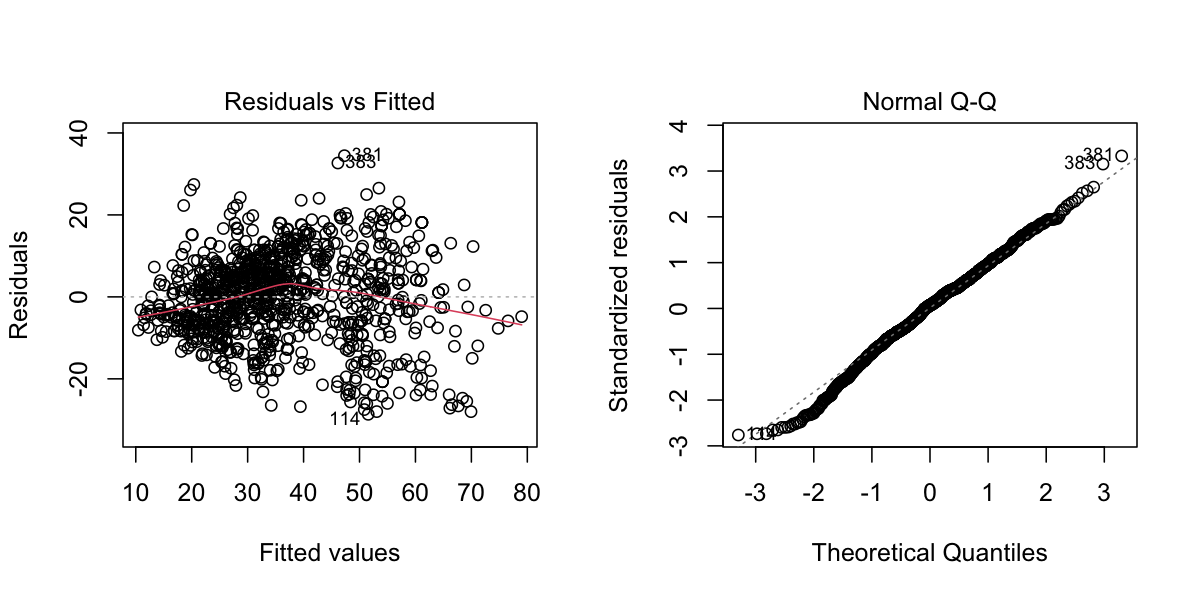

In [9]:
%%R -w 8 -h 4 -u in -r 150
# -w width
# -h height
# -u units (in: inches)
# -r resolution (dpi)

par(mfrow=c(1,2))
plot(linear_model,which=c(1,2))
par(mfrow=c(1,1))

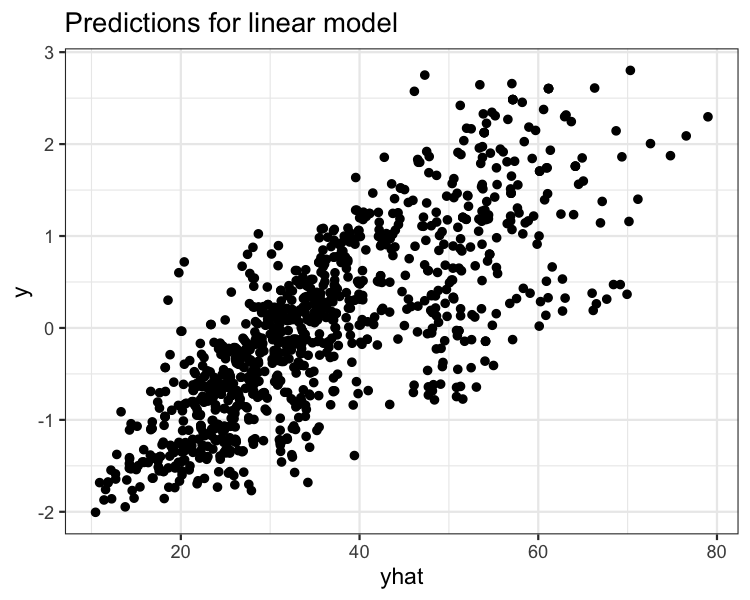

In [10]:
%%R -w 5 -h 4 -u in -r 150

suppressPackageStartupMessages(library(ggplot2))

yhat <- fitted(linear_model) # using the fitted method of linear models

qplot(yhat,y) + ggtitle('Predictions for linear model') + theme_bw()

# A more integrated interface: LOESS example

We will fit a local linear regression model on the `Concrete` dataset. Rather than writing cell blocks of R code, we will use R commands along with Python code. For this functionality, we will need some imports from the `rpy2.robjects` module.

- `importr` is used to load R packages. Here, we load the `R::stats` package, which contains the loess function. This is equivalent to importing a Python library named `stats`.
- The `numpy2ri` and `pandas2ri` submodules contain functions that enable conversion of numpy and pandas data structures to R format and vice versa.

In [11]:
from rpy2.robjects import r,pandas2ri,numpy2ri
from rpy2.robjects.packages import importr

# import the stats package
stats = importr('stats')

# activate automatic conversion of numpy,pandas data structures to R types
pandas2ri.activate()
numpy2ri.activate()

In [12]:
# standardize crt predictors and response
crt = (crt-crt.mean())/crt.std()

# fit a loess model
loess_model = stats.loess('Strength ~ Cement+Slag + Water+Age',data=crt,span=0.3,degree=1)

y_pred = r.predict(loess_model,crt)

In [13]:
loess_model

n,[1030]
fitted,[ 1.45868195 1.45868195 0.84766525 ... -0.60388861 -0.22318174 -0.16628731]
residuals,[ 1.18544118 0.10198137 -0.58116773 ... -0.1214884 0.04073182 -0.03831067]
...,...
x,[[ 2.4767117 -0.85647182 -0.91631925 -0.27959729] [ 2.4767117 -0.85647182 -0.91631925 -0.27959729] [ 0.4911867 0.79514022 2.17440495 3.55134048] ... [-1.26947162 0.75921041 0.52133579 -0.27959729] [-1.16804239 1.30742971 -0.27944275 -0.27959729] [-0.19393904 0.3083493 0.89128611 -0.27959729]]
y,[ 2.64412314 1.56066333 0.26649752 ... -0.72537701 -0.18244991 -0.20459799]
weights,[1. 1. 1. ... 1. 1. 1.]


In [14]:
y_pred

array([ 1.45868195,  1.45868195,  0.84766525, ..., -0.60388861,
       -0.22318174, -0.16628731])

In the class, we saw how to use the Cp criterion for selecting the hyperparameters. Here, we are going to use cross-validation instead.

In [15]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from itertools import product

In [16]:
# create a grid of hyperparameters
confs = pd.DataFrame(list(product(np.linspace(0.05,0.95,10),[0,1,2])),columns=['span','degree'])
confs.head()

,span,degree
0,0.05,0
1,0.05,1
2,0.05,2
3,0.15,0
4,0.15,1


In [17]:
# 5 fold CV
n_folds = 5
kf = KFold(n_splits=n_folds,shuffle=True,random_state=456)

# matrix of mean squared errors
# rows - folds
# columns - hyperparameter configurations
mses = np.empty((n_folds,confs.shape[0]))

for i,(train_index,test_index) in enumerate(kf.split(X)):
    # outer for loop is over fold: different train-test-splits
    for j in range(confs.shape[0]):
        # inner loop is over different hyperparameter configurations
        
        degree = confs['degree'].iloc[j]
        span = confs['span'].iloc[j]
        
        # fit a new loess model on the data
        loess_fold = stats.loess(
            'Strength ~ Cement+Slag + Water+Age',data=crt.iloc[train_index,:],span=span,degree=degree,
            control=stats.loess_control(surface="direct")
        )
        
        # compute test predictions
        y_test_pred = r.predict(loess_fold,crt.iloc[test_index,:])
        
        # compute metric-mean-squared error
        mses[i,j] = mean_squared_error(y[test_index],y_test_pred)

In [18]:
mse_cv = mses.mean(axis=0)
confs['r2_cv'] = 1-mse_cv/y.var() # convert mean squared error into r2

confs.sort_values(by='r2_cv',ascending=False).head(10)

,span,degree,r2_cv
11,0.35,2,0.860797
8,0.25,2,0.860381
14,0.45,2,0.859421
17,0.55,2,0.856490
5,0.15,2,0.855870
20,0.65,2,0.852575
1,0.05,1,0.848597
23,0.75,2,0.847475
26,0.85,2,0.840303
4,0.15,1,0.838280
